# EN3160 Assignment 2 on Fitting and Alignment
### Question 1


Parameters of the largest circle:
Center: (1341, 620)
Radius: 71
Sigma value: 3.0


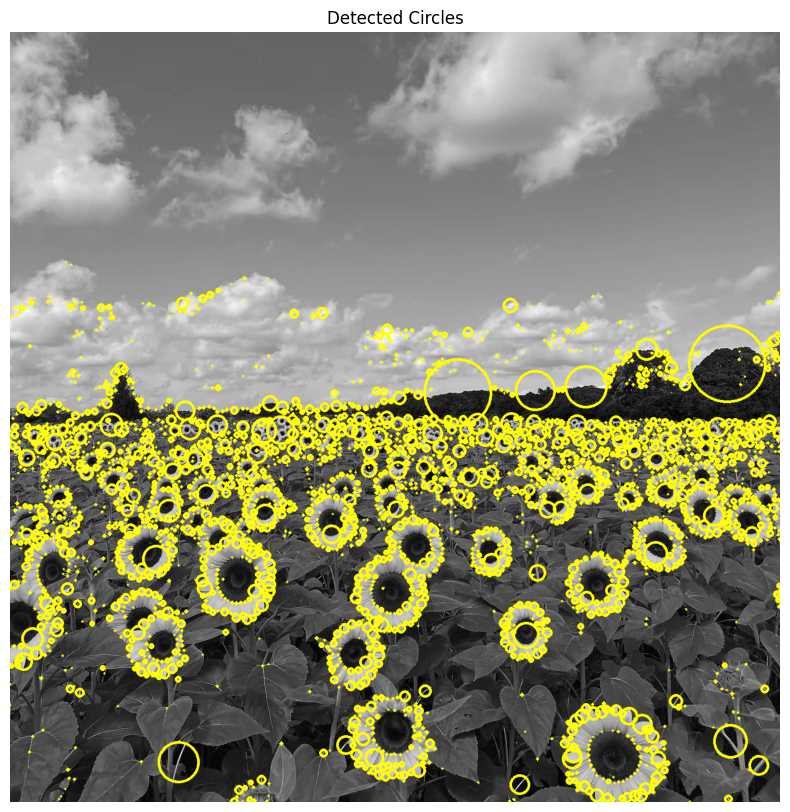

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the standard deviation (sigma) values for scale-space analysis
sigma_values = np.linspace(1, 3, 5)  # Adjust min_sigma, max_sigma, and num_sigma as needed
extrema_images = []

# Load the input grayscale image
image = cv2.imread(r'D:\VScode\JupyterWorks\assignment 2\the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_GRAYSCALE)

# Loop through each scale and compute the Laplacian response
for sigma in sigma_values:
    # Compute the size of the LoG kernel based on the scale
    kernel_size = int(6 * sigma)
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Create a meshgrid for X and Y coordinates
    hw = (kernel_size - 1) // 2
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    # Compute the LoG kernel
    log_kernel = (1 / (2 * np.pi * sigma**2)) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))

    # Compute the Laplacian of the LoG kernel
    laplacian_log_kernel = cv2.Laplacian(log_kernel, cv2.CV_64F)

    # Apply the LoG kernel to the image
    laplacian_response = cv2.filter2D(image, -1, laplacian_log_kernel)

    # Store the extrema image for this scale
    extrema_image = (laplacian_response > 0)  # Assuming extrema are positive in your case
    extrema_images.append(extrema_image)

# Calculate the absolute Laplacian values
abs_laplacian = np.abs(laplacian_response)

# Create a binary image where blobs are detected using the threshold
threshold = 0.37# Adjust the threshold as needed
blob_mask = abs_laplacian > threshold * abs_laplacian.max()

# Find contours in the blob mask
contours, _ = cv2.findContours(blob_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store detected circles
circles = []

# Loop through the detected contours and fit circles to them
for contour in contours:
    if len(contour) >= 1:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
largest_circle = circles[0]
center, radius, sigma = largest_circle

print("Parameters of the largest circle:")
print(f"Center: {center}")
print(f"Radius: {radius}")
print(f"Sigma value: {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 3

# Draw all detected circles with the specified line thickness on the original image
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv2.circle(output_image, center, radius, (0, 255, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()


### Question 2

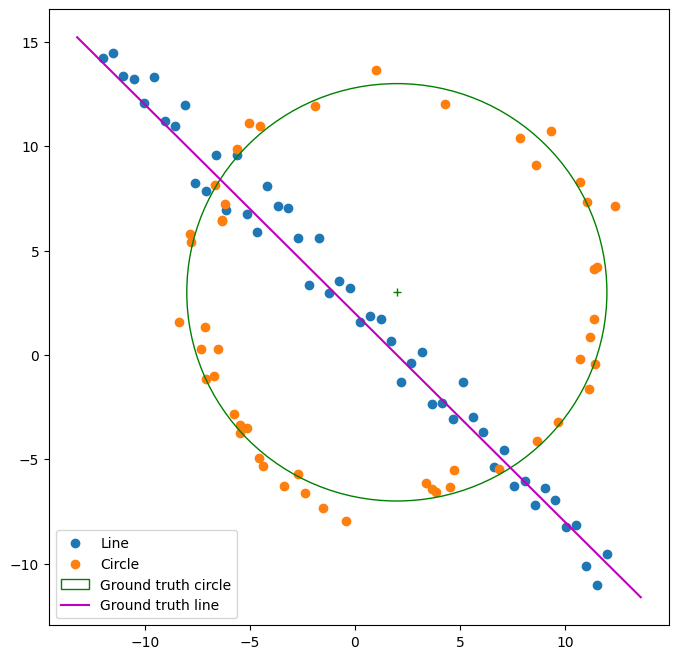

In [4]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import circle_fit as cf
import tikzplotlib

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16

t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)

X_c = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)

X_l = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_c, X_l))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_l[:, 0], X_l[:, 1], label='Line')
ax.scatter(X_c[:, 0], X_c[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()


In [7]:
import math
from scipy.optimize import minimize
import circle_fit as cf

N = X.shape[0]
X_ = X

def line_eq(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    mag = math.sqrt(dx ** 2 + dy ** 2)
    a = dy / mag
    b = -dx / mag
    d = (a * x1) + (b * y1)
    return a, b, d

def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a * X_[indices, 0] + b * X_[indices, 1] - d))

def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.abs(a * X_[:, 0] + b * X_[:, 1] - d)
    return error < t

t = 1
d = 0.4 * N
s = 2

inliers_line = []
max_iterations = 50
iteration = 0
best_model_line = []
best_error = np.inf
best_sample_line = []
res_only_with_sample = []
best_inliers_line = []

while iteration < max_iterations:
    indices = np.random.randint(0, N, s)
    x0 = np.array([1, 1, 0])
    res = minimize(fun=line_tls, args=(indices), x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t)
    if inliers_line.sum() > d:
        x0 = res.x
        res = minimize(fun=line_tls, args=inliers_line, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
        if res.fun < best_error:
            best_model_line = res.x
            best_error = res.fun
            best_sample_line = X_[indices, :]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1

print("Best line model", best_model_line)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.532596537339858e-11
            Iterations: 17
            Function evaluations: 78
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.9901849532279478e-11
            Iterations: 22
            Function evaluations: 112
            Gradient evaluations: 22
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4819404132682187e-08
            Iterations: 10
            Function evaluations: 46
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.681779139127406e-07
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.3298053505035622e-08
            Iterations: 6
        

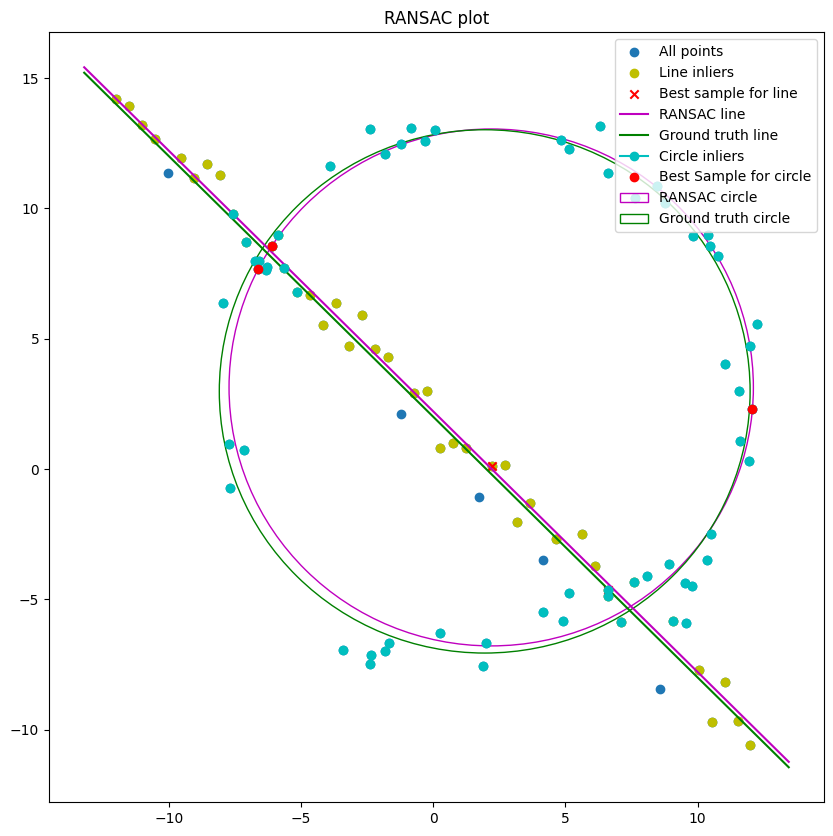

In [8]:
def circ_from_pts(x1, x2, x3):
    denom_1 = ((x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]))
    denom_2 = ((x1[0] - x2[0]) * (x2[1] - x3[1]) - (x2[1] - x1[1]) * (x3[0] - x2[0]))

    if denom_1 != 0 and denom_2 != 0:
        a = 0.5 * ((x2[1] - x3[1]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2) + (x2[1] - x1[1]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2)) / denom_1
        b = 0.5 * ((x1[0] - x2[0]) * (x2[0]**2 + x2[1]**2 - x3[0]**2 - x3[1]**2) + (x3[0] - x2[0]) * (x1[0]**2 + x1[1]**2 - x2[0]**2 - x2[1]**2)) / denom_2
        c = -x3[0]**2 - x3[1]**2 + 2*a*x3[0] + 2*b*x3[1]

        r = np.sqrt(a**2 + b**2 - c)
    else:
        a, b, r = None, None, None

    return a, b, r

def get_inliers(a, b, r, X, d):
    count = 0
    best_fit_inliers = None

    for i in range(X.shape[0]):
        distance = abs(((X[i,0] - a)**2 + (X[i,1] - b)**2)**0.5 - r)

        if distance < d:
            count += 1

            if type(best_fit_inliers) == type(None):
                best_fit_inliers = np.array([X[i,:]])
            else:
                best_fit_inliers = np.concatenate((best_fit_inliers, X[i,:].reshape(1, -1)), axis=0)

    return count, best_fit_inliers

def ransac(X): 
    S = 3
    d = 1.96
    e = 0.50
    p = 0.99
    N = int(np.ceil(np.log(1-p)/np.log(1-(1-e)**S)))

    best_fit_circle = None
    best_fit_x = None
    best_inlier_count = 0

    for _ in range(N):
        x = []

        for i in range(S):
            hold = X[np.random.randint(0, 100), :]

            if len(x) == 0:
                x.append(hold)
            elif np.array_equal(hold, x[-1]):                
                while np.array_equal(hold, x[-1]):
                    hold = X[np.random.randint(0, 100), :]

                x.append(hold)
            else:
                x.append(hold)

        a, b, r = circ_from_pts(x[0], x[1], x[2])

        if a == None:
            continue

        count, inliers = get_inliers(a, b, r, X, d)

        if count > best_inlier_count:
            best_fit_circle = plt.Circle((a, b), r, color='m', fill=False, label="RANSAC circle")
            best_fit_x = x
            best_fit_inliers = inliers
            best_inlier_count = count

    if best_inlier_count < e:
        print("The RANSAC algorithm did not find a suitable model")
        return None, None, None, None

    xc, yc, r, _ = cf.least_squares_circle(best_fit_inliers)

    ransac_circle = plt.Circle((xc, yc), r, color='g', fill=False, label="Ground truth circle")

    return ransac_circle, best_fit_circle, best_fit_x, best_fit_inliers

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(X_[:,0], X_[:,1], label='All points')
ax.scatter(X_[best_inliers_line, 0], X_[best_inliers_line, 1], color='y', label='Line inliers')
ax.scatter(best_sample_line[:, 0], best_sample_line[:, 1], marker='x', color='r', label='Best sample for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1] * x_ + best_model_line[2]) / best_model_line[1]
plt.plot(x_, y_, color='m', label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='g', label='Ground truth line')

ransac_circle, best_fit_circle, x, inliers = ransac(X)

if ransac_circle != None:

    if type(inliers) != type(None):
        for point in inliers:
            if np.array_equal(point, inliers[-1]):
                ax.plot(point[0], point[1], marker='o', color='c', label="Circle inliers")
            else:
                ax.plot(point[0], point[1], marker='o', color='c')

    for point in x:
        if np.array_equal(point, x[-1]):
            ax.plot(point[0], point[1], 'ro', label="Best Sample for circle")
        else:
            ax.plot(point[0], point[1], 'ro')

    ax.add_patch(best_fit_circle)
    ax.add_patch(ransac_circle)
    ax.set_title("RANSAC plot")
    ax.legend(loc="upper right")


### Question 3


(192, 383, 3)
(483, 610, 3)
(277, 427, 3)
(183, 275, 3)
(720, 1280, 3)
(455, 728, 3)


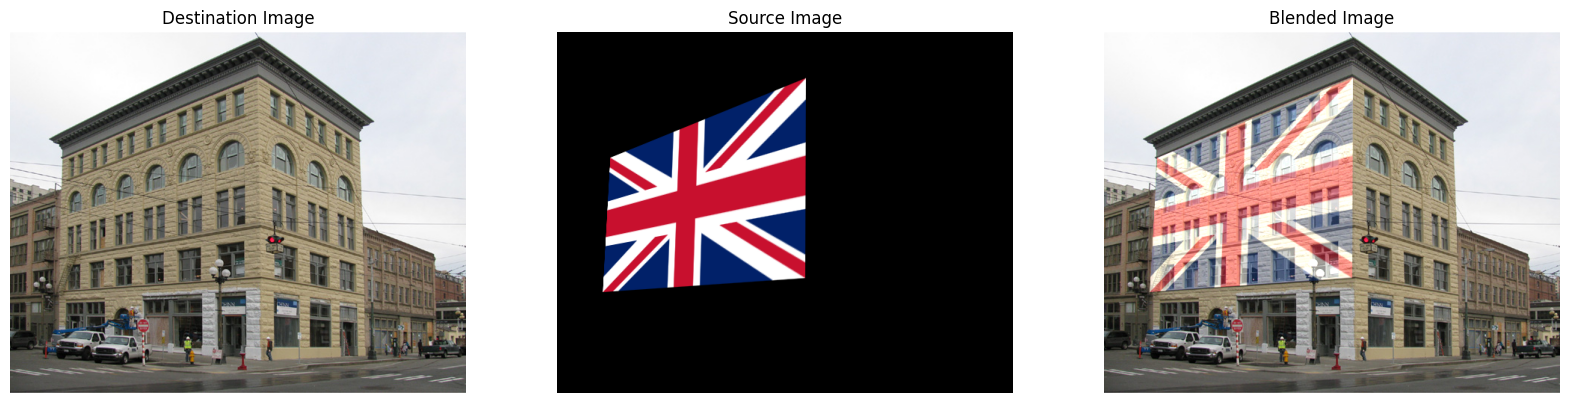

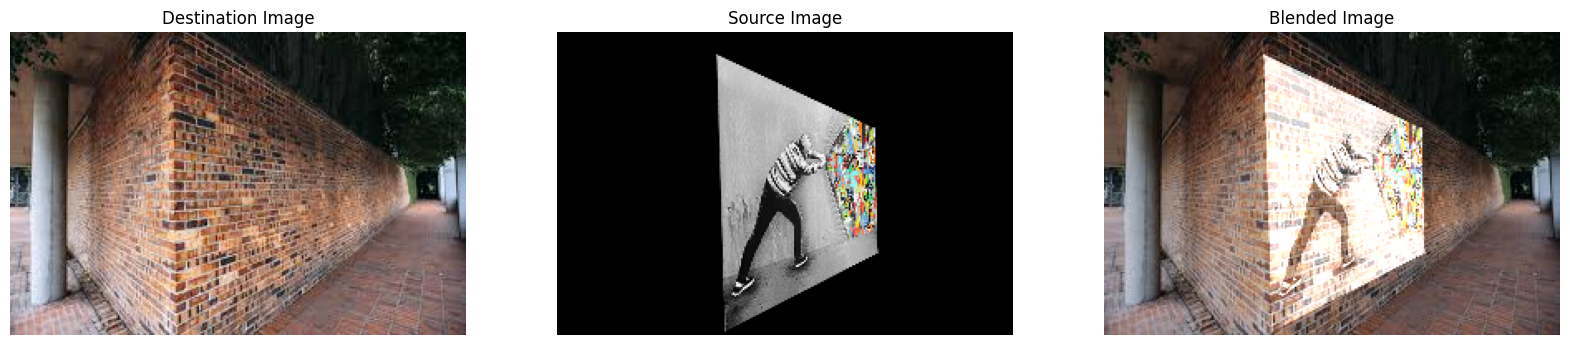

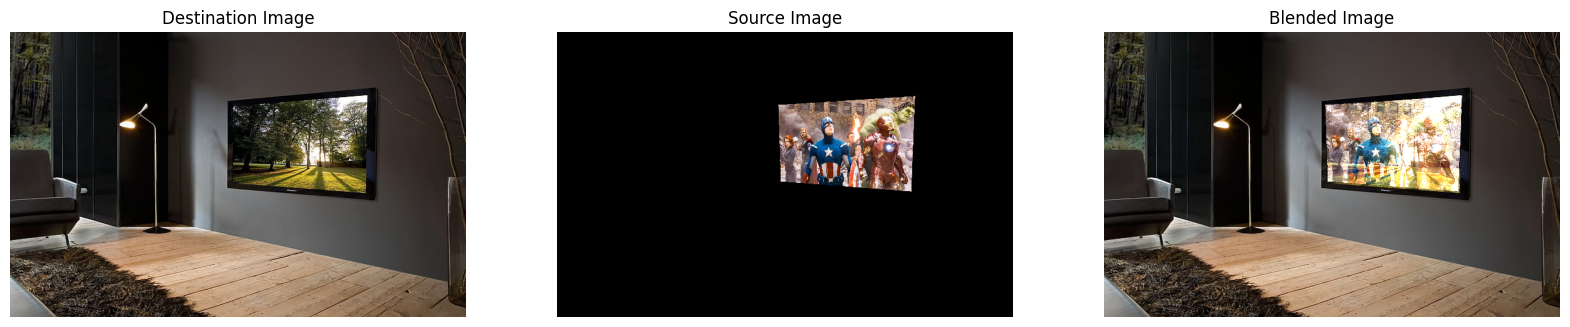

In [51]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load destination and source images and specify blending coefficients
images = [cv.imread(r'D:\VScode\JupyterWorks\assignment 2\structural building.jpg'), cv.imread(r'D:\VScode\JupyterWorks\assignment 2\side wall.jpg'), cv.imread(r'D:\VScode\JupyterWorks\assignment 2\tv room.jpg')]
coffs = [(1, 0.5, 0.2), (0.8, 1, 0), (1, 1, 0)]
source_img = [cv.imread(r'D:\VScode\JupyterWorks\assignment 2\Flag of the United Kingdom.jpeg'), cv.imread(r'D:\VScode\JupyterWorks\assignment 2\wall paint.png'), cv.imread(r'D:\VScode\JupyterWorks\assignment 2\avengers.jpg')]

# Loop through each pair of destination and source images
for i in range(len(images)):
    flag = source_img[i]
    points = []
    clicks = 0
    print(source_img[i].shape)

    # Define a mouse click event handler to collect user-defined points
    def click(event, x, y, flags, params):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append([x, y])

    img = images[i]
    print(img.shape)

    # Display the destination image and collect user-defined points
    cv.imshow('image', img)
    cv.setMouseCallback('image', click)
    cv.waitKey(0)
    cv.destroyAllWindows()

    if flag is None:
        print(f"Error: Could not load source image '{source_img[i]}'")
        continue

    # Define the source and destination points for the perspective transformation
    w, h = flag.shape[1], flag.shape[0]
    pts_src = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
    pts_dst = np.array(points)

    # Compute the homography matrix for the perspective transformation
    h, status = cv.findHomography(pts_src, pts_dst)

    # Apply the perspective transformation to the source image
    im_out = cv.warpPerspective(flag, h, (img.shape[1], img.shape[0]))

    # Blend the destination and transformed source images using specified coefficients
    blended_img = cv.addWeighted(img, coffs[i][0], im_out, coffs[i][1], coffs[i][2])

    # Display the blended image
    im = [img, im_out, blended_img]
    cv.imshow("Blended Image", blended_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

    # # Create a subplot for displaying the destination image, source image, and blended image
    fig, ax = plt.subplots(1, 3, figsize=(20, 20), facecolor='white')
    titles = ['Destination Image', 'Source Image', 'Blended Image']

    for j in range(3):
        # Convert and display the OpenCV images using Matplotlib
        transformed_img_ = cv.cvtColor(im[j], cv.COLOR_BGR2RGB)
        ax[j].axis('off')
        ax[j].imshow(transformed_img_)
        ax[j].set_title(titles[j])

plt.show()


### Question 4

((< cv2.DMatch 000002C7EAE01070>, < cv2.DMatch 000002C7EAE012D0>), (< cv2.DMatch 000002C7EAE00F50>, < cv2.DMatch 000002C7EAE01170>), (< cv2.DMatch 000002C7EAE00970>, < cv2.DMatch 000002C7EAE01190>), (< cv2.DMatch 000002C7EAE01410>, < cv2.DMatch 000002C7EAE01210>), (< cv2.DMatch 000002C7EAE01250>, < cv2.DMatch 000002C7EAE011F0>))


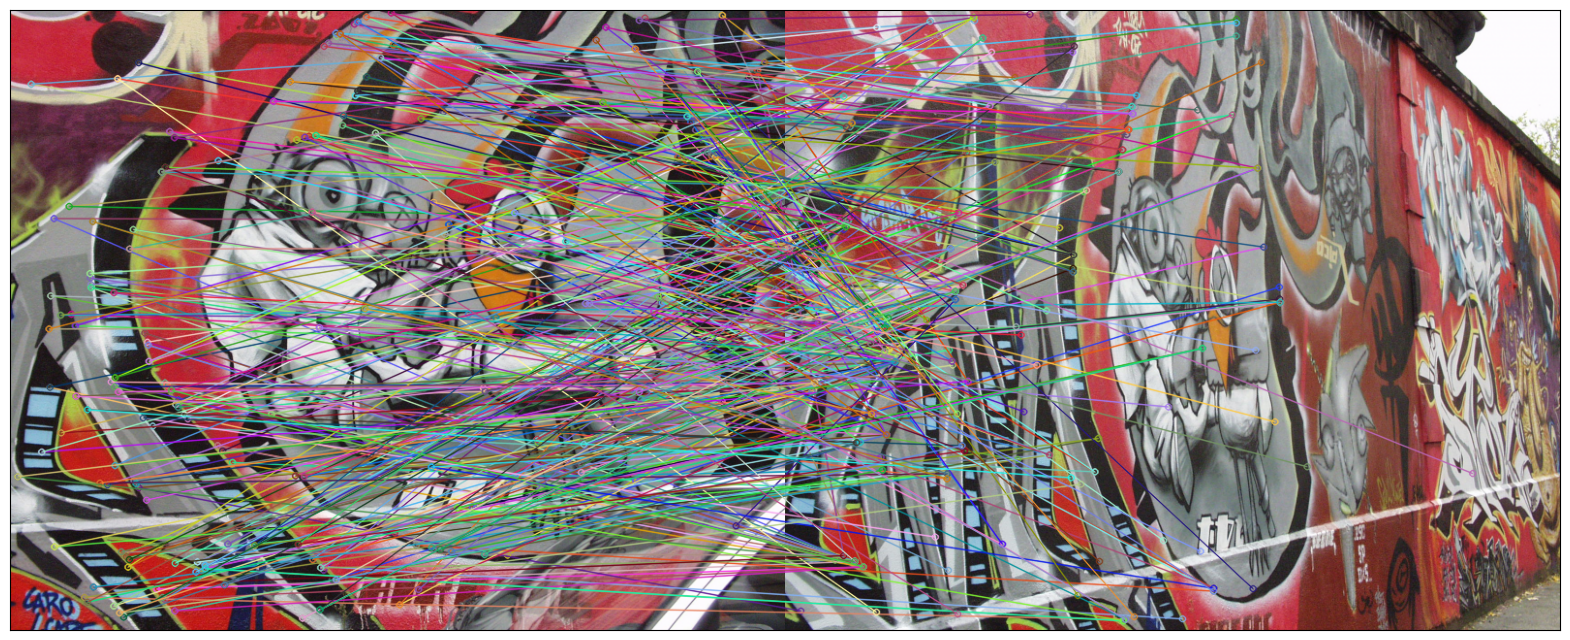

In [23]:
# Import necessary libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread(r'D:\VScode\JupyterWorks\assignment 2\img1.ppm')
img5 = cv.imread(r'D:\VScode\JupyterWorks\assignment 2\img5.ppm')

# Convert images to grayscale
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

# Convert images to RGB format
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(img5, cv.COLOR_BGR2RGB)

# Create SIFT detector
sift = cv.SIFT_create()

# Create BFMatcher
bf = cv.BFMatcher()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

# Match features using BFMatcher
matches = bf.knnMatch(descriptors1, descriptors5, k=2)
print(matches[:5])

# Sort matches based on distance
matches = sorted(matches, key=lambda x: x[0].distance)

# Draw the best 200 matches
out_img = cv.drawMatchesKnn(img1, keypoints1, img5, keypoints5, matches[:200], img5, flags=2)

# Display the matched image
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(out_img)
ax.set_xticks([])
ax.set_yticks([])

plt.show()


In [28]:
import cv2 as cv
import numpy as np

def findFeatures(img):
    # Detect SIFT features and compute descriptors
    sift = cv.SIFT_create()
    key, des = sift.detectAndCompute(img, None)
    return key, des

def findMatches(des1, des2):
    # Match features using BFMatcher
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    return matches

def calHomography(sample):
    # Calculate homography matrix using a sample of point correspondences
    A = []
    for i in range(len(sample)):
        x1, y1, x2, y2 = sample[i, 0], sample[i, 1], sample[i, 2], sample[i, 3]
        A.append([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])

    A = np.matrix(A)
    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    return H

def calDistance(H, correspondence):
    # Calculate the distance between correspondence points using the homography matrix
    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(H, p1)
    estimatep2 = (1 / estimatep2.item(2)) * estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def RANSAC(corres, threshold):
    max_inliers = []
    homography = []

    for i in range(100):
        # Randomly select four correspondences as a sample
        corr_sample = corres[np.random.randint(0, len(corres), size=4)]
        
        # Calculate the homography matrix using the sample
        h = calHomography(corr_sample)
        
        inliers = np.zeros((1, 4))
        
        for j in range(len(corres)):
            distance = calDistance(h, corres[j])
            if distance < 5:
                inliers = np.vstack((inliers, corres[j]))
               
        inliers = np.delete(inliers, 0, 0)

        if len(inliers) > threshold:
            max_inliers = inliers
            homography = calHomography(max_inliers)
       
    return homography, max_inliers

# Load images
img_lst = [cv.imread(f'D:/VScode/JupyterWorks/assignment 2/img{i}.ppm') for i in range(1, 6)]
#img_lst = [cv.imread(f'graf/img{i}.ppm') for i in range(1, 6)]

homographs = []
estimated_threshold = 100

for i in range(4):
    correspondence = []
    
    # Find SIFT features and matches between adjacent images
    key1, des1 = findFeatures(img_lst[i])
    key2, des2 = findFeatures(img_lst[i + 1])
    matches = findMatches(des1, des2)

    # Extract correspondence points
    for match in matches:
        (x1, y1) = key1[match[0].queryIdx].pt
        (x2, y2) = key2[match[0].trainIdx].pt
        correspondence.append([x1, y1, x2, y2])

    corres = np.matrix(correspondence)
    
    # Apply RANSAC to estimate homography
    H, inliers = RANSAC(corres, estimated_threshold)
    homographs.append(H)

# Calculate the final homography by multiplying individual homographies
final_homograph = homographs[3] @ homographs[2] @ homographs[1] @ homographs[0]
final_homograph = (1 / final_homograph.item(8)) * final_homograph

print('Calculated Homography\n', final_homograph)
print('Number of inliers', len(inliers))

# Print the original homography for reference
print('Original Homography\n', open(r'D:\VScode\JupyterWorks\assignment 2\H1to5p').read())


Calculated Homography
 [[ 6.40119435e-01  8.14959217e-02  2.19807299e+02]
 [ 2.27816249e-01  1.19939972e+00 -2.94880960e+01]
 [ 5.11414728e-04  2.10166522e-05  1.00000000e+00]]
Number of inliers 1273
Original Homography
    6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



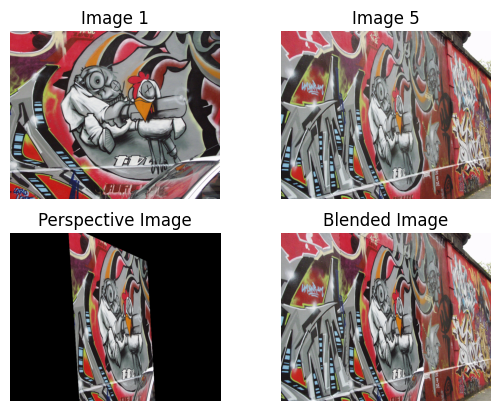

In [31]:
# Load the calculated homography
calculated_H = final_homograph

# Load images
img1 = cv.imread(r'D:\VScode\JupyterWorks\assignment 2\img1.ppm')
img5 = cv.imread(r'D:\VScode\JupyterWorks\assignment 2\img5.ppm')

# Plot img1 and img5
plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('Image 5')
plt.axis('off')

# Warp img1 to img5's perspective using the calculated homography
image_perspective = cv.warpPerspective(img1, calculated_H, (img5.shape[1], img5.shape[0]))

plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective Image')
plt.axis('off')

# Create a mask and blend img5 and the warped image
threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)

plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
plt.title('Blended Image')
plt.axis('off')

plt.show()


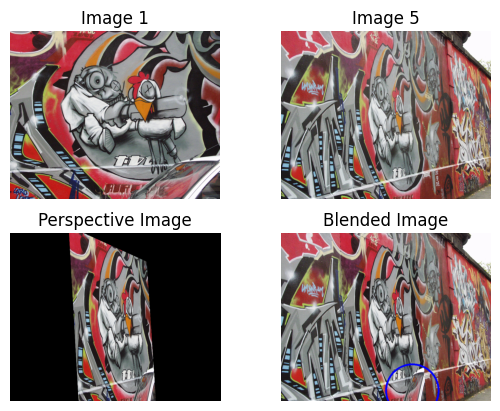

In [33]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv.imread(r'D:\VScode\JupyterWorks\assignment 2\img1.ppm')
img5 = cv.imread(r'D:\VScode\JupyterWorks\assignment 2\img5.ppm')

# Plot img1 and img5
plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('Image 5')
plt.axis('off')

# Load the original homography matrix from file
h_text = open(r'D:\VScode\JupyterWorks\assignment 2\H1to5p', 'r')

# Convert h_text to a homography matrix
original_H = []
for line in h_text:
    line = line.strip()
    line = line.split()
    line = [float(i) for i in line]
    original_H.append(line)

original_H = np.matrix(original_H)

# Warp img1 to img5's perspective using the original homography
image_perspective = cv.warpPerspective(img1, original_H, (img5.shape[1], img5.shape[0]))

plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(image_perspective, cv.COLOR_BGR2RGB))
plt.title('Perspective Image')
plt.axis('off')

# Create a mask and blend img5 and the warped image
threshold, mask = cv.threshold(cv.cvtColor(image_perspective, cv.COLOR_BGR2GRAY), 1, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
img5_bg = cv.bitwise_and(img5, img5, mask=mask_inv)
dst = cv.addWeighted(img5_bg, 1, image_perspective, 1, 0)
output_image = cv.cvtColor(dst, cv.COLOR_BGR2RGB)

# Draw a circle on the blended image
difference = cv.circle(output_image, (500, 600), 100, (0, 0, 255), 5)

plt.subplot(2, 2, 4)
plt.imshow(difference)
plt.title('Blended Image')
plt.axis('off')

plt.show()
